In [22]:
#Import necessary libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
#Load the data

df = pd.read_csv("AirPassengers.csv")

df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.shape

(144, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
#Time frame of the dataset

print("Start date:",df.min()[0])

print("End date:",df.max()[0])

Start date: 1949-01
End date: 1960-12


#### Data Transformation

In [7]:
#Format Date Variable

df["Month"] = pd.to_datetime(df["Month"],
                             format = "%Y-%m-%d")

In [8]:
#Renaming variables

df = df.rename(columns = {"Month": "ds",
                          "#Passengers": "y"})

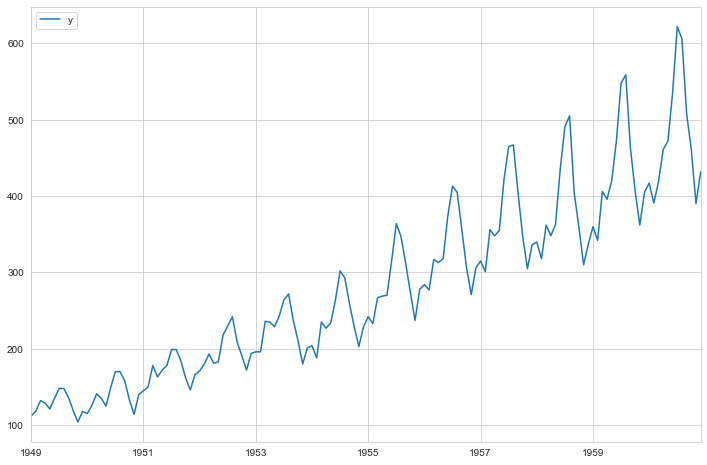

In [9]:
#Visualization

df.set_index("ds").plot(figsize = (12,8),
                        legend = True)

plt.xlabel(None);

#### Training and Test Sets

In [10]:
test_months = 12

training_set = df.iloc[:-test_months, :]

test_set = df.iloc[-test_months:, :]

#### Prophet

In [11]:
#Build and fit the model

m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = False,
            daily_seasonality = False,
            seasonality_mode = "multiplicative")

m.fit(training_set)

In [12]:
#Create future dataframe

future = m.make_future_dataframe(periods = test_months,
                                 freq = "MS")

In [13]:
#Forecast

forecast = m.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,1949-01-01,102.862147,89.359351,115.474514
1,1949-02-01,98.712503,85.447982,111.167902
2,1949-03-01,117.965650,105.049513,130.782924
3,1949-04-01,115.445146,102.606150,129.818054
4,1949-05-01,118.052204,104.319370,131.523554


In [14]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,114.331076,89.359351,115.474514,114.331076,114.331076,-0.100313,-0.100313,-0.100313,-0.100313,-0.100313,-0.100313,0.0,0.0,0.0,102.862147
1,1949-02-01,116.096526,85.447982,111.167902,116.096526,116.096526,-0.149738,-0.149738,-0.149738,-0.149738,-0.149738,-0.149738,0.0,0.0,0.0,98.712503
2,1949-03-01,117.691126,105.049513,130.782924,117.691126,117.691126,0.002333,0.002333,0.002333,0.002333,0.002333,0.002333,0.0,0.0,0.0,117.965650
3,1949-04-01,119.456577,102.606150,129.818054,119.456577,119.456577,-0.033581,-0.033581,-0.033581,-0.033581,-0.033581,-0.033581,0.0,0.0,0.0,115.445146
4,1949-05-01,121.165077,104.319370,131.523554,121.165077,121.165077,-0.025691,-0.025691,-0.025691,-0.025691,-0.025691,-0.025691,0.0,0.0,0.0,118.052204


#### XGBoost Preparation

In [16]:
#Isolate the relevant variables for XGBoost dataframe

prophet_variables = forecast.loc[:, ["trend", "yearly"]]

In [19]:
#Create XGBoost dataframe

df_xgb = pd.concat([df,prophet_variables], axis = 1)

df_xgb

,ds,y,trend,yearly
0,1949-01-01,112,114.331076,-0.100313
1,1949-02-01,118,116.096526,-0.149738
2,1949-03-01,132,117.691126,0.002333
3,1949-04-01,129,119.456577,-0.033581
4,1949-05-01,121,121.165077,-0.025691
...,...,...,...,...
139,1960-08-01,606,465.062470,0.233336
140,1960-09-01,508,467.876141,0.060954
141,1960-10-01,461,470.599048,-0.079524
142,1960-11-01,390,473.412718,-0.198389


In [20]:
#Training and test sets

test_months = 12

training_set = df_xgb.iloc[:-test_months, :]

test_set = df_xgb.iloc[-test_months:, :]

In [21]:
#Isolate X (features) & Y (target-variable)

y_train = training_set["y"]

y_test = test_set["y"]

X_train = training_set.iloc[:, 2:]

X_test = test_set.iloc[:, 2:]

In [23]:
#Create XGBoost matrices

Train = xgb.DMatrix(data = X_train,
                    label = y_train)

Test = xgb.DMatrix(data = X_test,
                   label = y_test)

#### XGBoost

In [24]:
#Set up the parameters

parameters = {"learning_rate": 0.1,
              "max_depth": 3,
              "colsample_bytree": 1,
              "subsample": 1,
              "min_child_weight": 1,
              "gamma": 1,
              "random_state": 45,
              "eval_metric": "rmse",
              "objetive": "reg:squarederror"}

In [25]:
#XGBoost model

model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100,
                  evals = [(Test, "y")],
                  verbose_eval = 15)

[12:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	y-rmse:445.90156
[15]	y-rmse:168.80191
[30]	y-rmse:86.31009
[45]	y-rmse:62.02578
[60]	y-rmse:55.77084
[75]	y-rmse:53.40314
[90]	y-rmse:52.36971
[99]	y-rmse:52.08113


#### Forecasting and Visualization

In [28]:
#Predictions

xgb_predictions = pd.Series(model.predict(Test), name = "XGBoost")

xgb_predictions.index = test_set["ds"]

xgb_predictions

ds
1960-01-01    405.499481
1960-02-01    384.328644
1960-03-01    419.332672
1960-04-01    405.280548
1960-05-01    405.280548
1960-06-01    474.086945
1960-07-01    535.569702
1960-08-01    535.569702
1960-09-01    458.242310
1960-10-01    405.279083
1960-11-01    361.574371
1960-12-01    384.181335
Name: XGBoost, dtype: float32

In [29]:
#Index

training_set.index = training_set["ds"]

test_set.index = test_set["ds"]

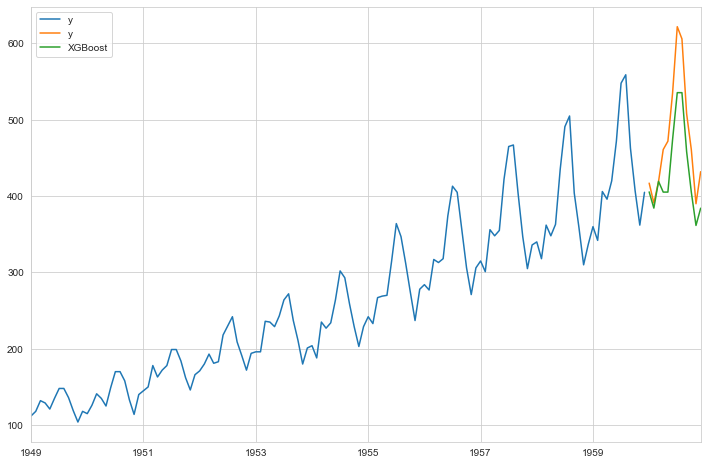

In [34]:
#Visualization

training_set["y"].plot(figsize = (12,8),
                       legend = True)

test_set["y"].plot(legend = True)

xgb_predictions.plot(legend = True)

plt.xlabel(None);

#### Model Evaluation

In [35]:
#MAE and RMSE

print("MAE:", round(mean_absolute_error(test_set["y"], xgb_predictions),2))
print("RMSE:", round(np.sqrt(mean_squared_error(test_set["y"], xgb_predictions)),2))

MAE: 45.04
RMSE: 52.08


In [36]:
#MAPE

def MAPE(y_true, y_preds):
    y_true, y_pred = np.array(y_true), np.array(y_preds)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAPE:",round(MAPE(test_set["y"], xgb_predictions),2))

MAPE: 8.99


#### Export Predictions

In [37]:
xgb_predictions.to_csv("AirPassengers_12Months_Forecast(XGBoost).csv", index = True)